In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler

# Processamento


In [168]:
def load_data(filepath):
    return pd.read_csv(filepath)

In [ ]:
def process_data(df):
    numeric_cols = df.select_dtypes(include=[np.number])
    
    Q1 = numeric_cols.quantile(0.25)
    Q3 = numeric_cols.quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))).any(axis=1)].copy()
    
    for column in df.columns:
        missing_percentage = df[column].isna().mean()
        if missing_percentage > 0 and missing_percentage <= 0.2:
            if df[column].dtype in [np.float64, np.int64]:
                df[column] = df[column].fillna(df[column].mean())  

    df = df.loc[:, df.isna().mean() < 0.8].copy()
    df = pd.get_dummies(df, drop_first=True)
    df = df.apply(pd.to_numeric, errors='coerce').dropna()

    return df

In [ ]:
def feature_selection_nn(df, n_features=15):

    df = df.dropna().copy()
    X = df.select_dtypes(include=[np.number])  #
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector = selector.fit(X_scaled, np.ones(X_scaled.shape[0]))  
    selected_features = X.columns[selector.support_].tolist()
    
    print("Atributos selecionados:", selected_features)
    
    return selected_features


# Usando as funções

In [208]:
if __name__ == "__main__":
    filepath = r'C:\Users\annab\OneDrive\Documentos\GitHub\Colabs\RECPAD\Processamento\df_processed'
    
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"O arquivo especificado não foi encontrado: {filepath}")
    
    df_processed = load_data(filepath)
    selected_features = feature_selection_nn(df_processed, n_features=16)

    df_final = df_processed[selected_features]
    print("Atributos selecionados:", df_final)

Atributos selecionados: ['SERIESCMAE', 'DTNASCMAE', 'RACACORMAE', 'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES', 'IDADEPAI', 'DTULTMENST', 'CONSPRENAT', 'MESPRENAT', 'ESCMAEAGR1', 'STDNEPIDEM', 'STDNNOVA', 'CODPAISRES', 'PARIDADE', 'CLASSE']
Atributos selecionados:         SERIESCMAE   DTNASCMAE  RACACORMAE  QTDGESTANT  QTDPARTNOR  \
0              3.0  31051980.0         4.0         0.0         0.0   
1              NaN  14061976.0         4.0         2.0         0.0   
2              NaN   7021985.0         4.0         0.0         0.0   
3              NaN   1031983.0         4.0         2.0         0.0   
4              2.0  18122000.0         4.0         0.0         0.0   
...            ...         ...         ...         ...         ...   
515639         NaN  25021998.0         4.0         1.0         0.0   
515640         4.0         NaN         4.0         1.0         0.0   
515641         8.0   7051991.0         4.0         1.0         1.0   
515642         NaN  18101996.0         

In [ ]:
train_df, test_df = train_test_split(df_final, test_size=0.3, stratify=df_final['CLASSE'], random_state=42)
train_df
test_df['CLASSE'].value_counts()


CLASSE
0    137626
1     17068
Name: count, dtype: int64

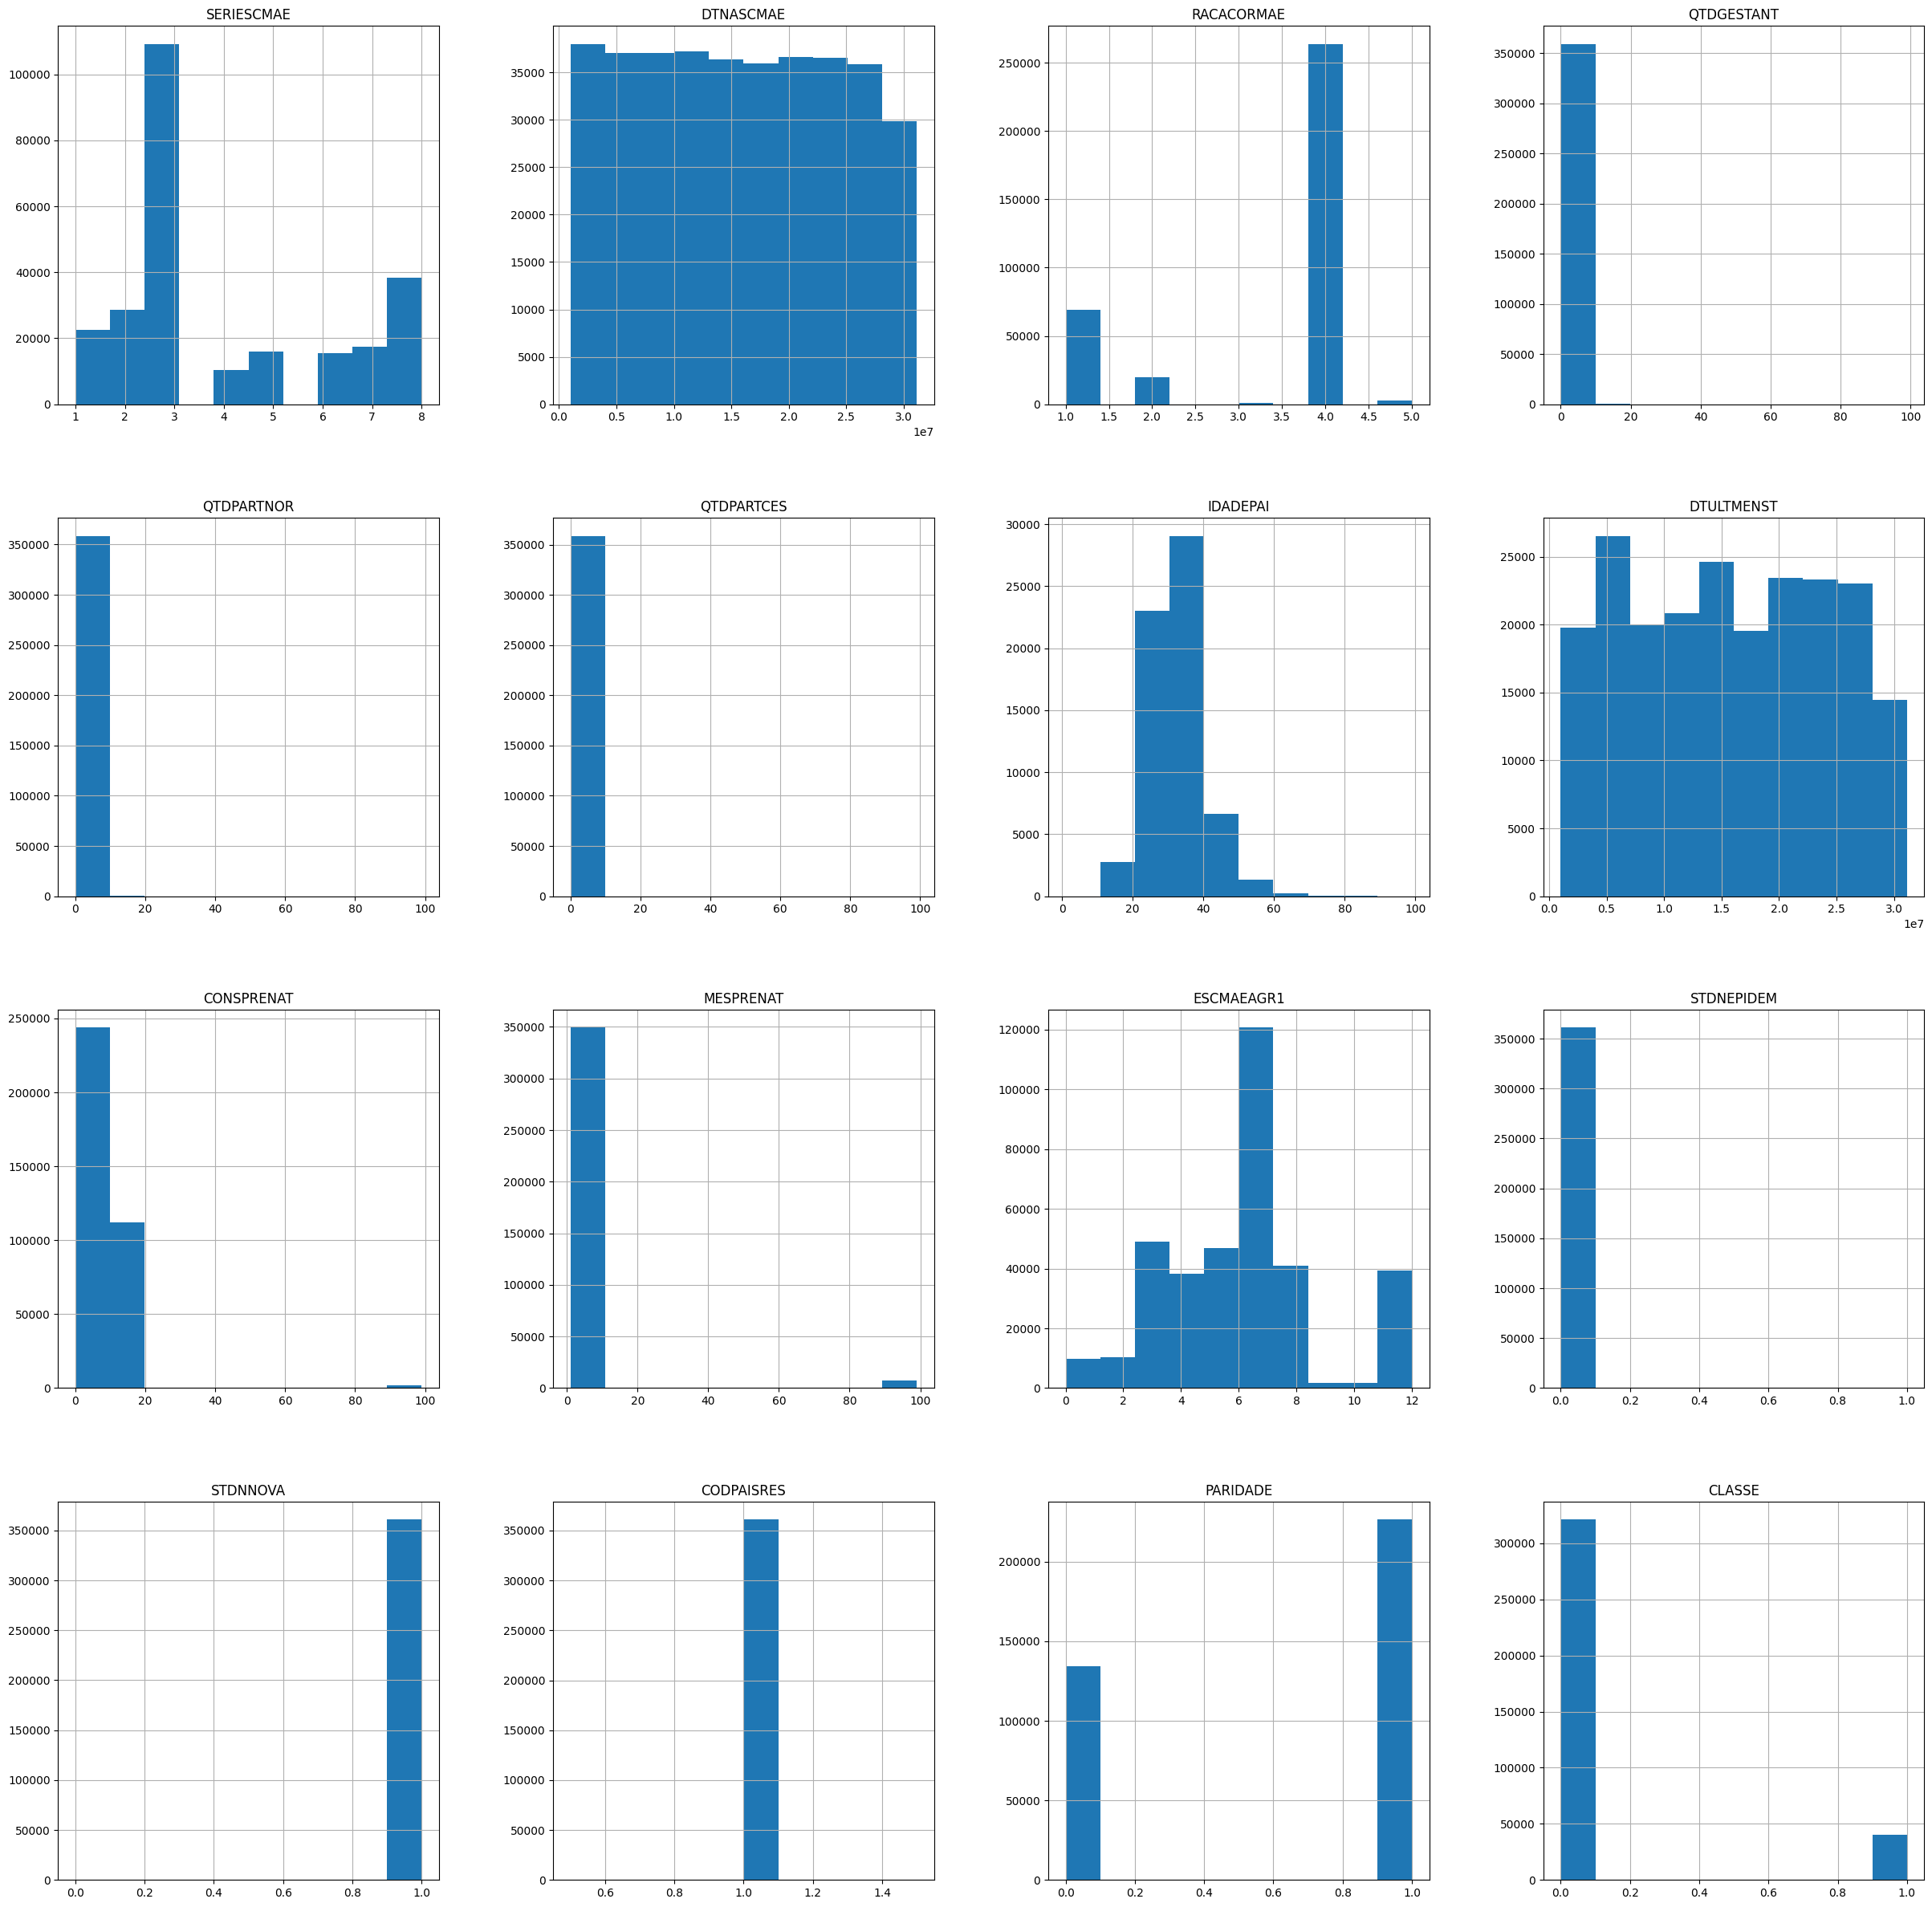

In [212]:
train_df.hist(figsize=(30,30))
plt.show()

In [ ]:
train_df['CLASSE'].value_counts()

CLASSE
0    321031
1     39919
Name: count, dtype: int64

In [ ]:
X_train = train_df.drop(columns=['CLASSE'])
y_train = train_df['CLASSE']
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

# Treinamento dos modelos

# Decision Tree

Melhores parâmetros encontrados: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.93      0.65      0.76    137626
           1       0.18      0.61      0.27     17068

    accuracy                           0.64    154694
   macro avg       0.55      0.63      0.52    154694
weighted avg       0.85      0.64      0.71    154694



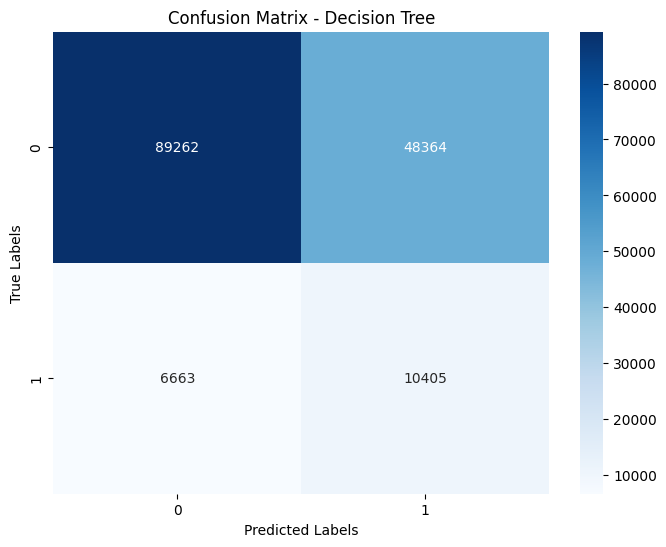

In [230]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

X_train = train_df.drop(columns=['CLASSE'])
y_train = train_df['CLASSE']
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

X_test = test_df.drop(columns=['CLASSE'])
y_test = test_df['CLASSE']

    # Ajustando hiperparâmetros do modelo Decision Tree
param_grid_dt = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 10]
  }

dt_model = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_dt.fit(X_train_balanced, y_train_balanced)
best_params_dt = grid_search_dt.best_params_
print("Melhores parâmetros encontrados:", best_params_dt)

    # Treinando o melhor modelo Decision Tree
best_dt_model = DecisionTreeClassifier(random_state=42, **best_params_dt)
best_dt_model.fit(X_train_balanced, y_train_balanced)

    # Avaliando o modelo
y_pred_dt = best_dt_model.predict(X_test)
print(classification_report(y_test, y_pred_dt))

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap="Blues",
                xticklabels=best_dt_model.classes_,
                yticklabels=best_dt_model.classes_,
                cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

Melhor Threshold Calculado: 0.5908
Melhor F1-Score Correspondente: 0.2806


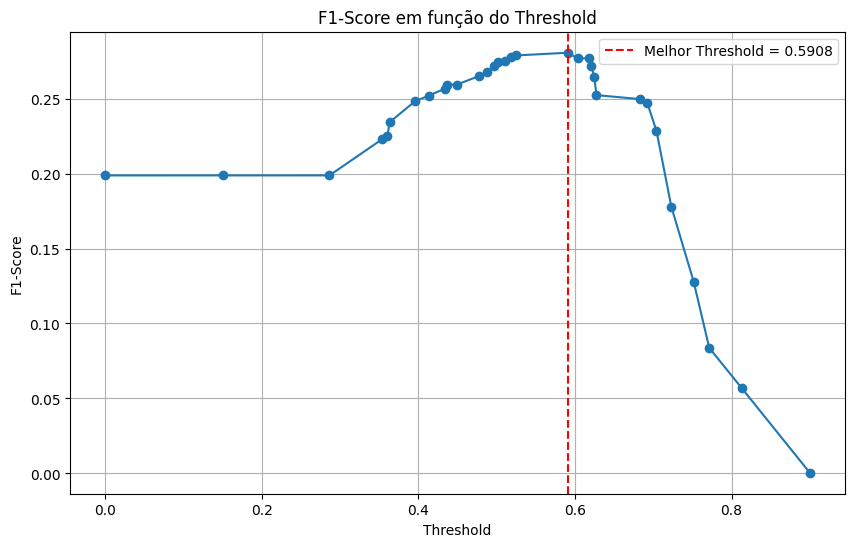

In [231]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

y_prob_dt = best_dt_model.predict_proba(X_test)[:, 1]
unique_thresholds = np.sort(np.unique(y_prob_dt))

f1_scores = []

for threshold in unique_thresholds:
    y_pred_threshold = (y_prob_dt >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

best_threshold_index = np.argmax(f1_scores)
best_threshold = unique_thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f"Melhor Threshold Calculado: {best_threshold:.4f}")
print(f"Melhor F1-Score Correspondente: {best_f1_score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(unique_thresholds, f1_scores, marker='o')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f"Melhor Threshold = {best_threshold:.4f}")
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score em função do Threshold')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

y_prob_dt = best_dt_model.predict_proba(X_test)[:, 1]

threshold = 0.59
y_pred_threshold = (y_prob_dt >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()

accuracy = accuracy_score(y_test, y_pred_threshold)
precision = precision_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = precision
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
correctly_classified = accuracy * len(y_test)

print(f"Threshold Utilizado: {threshold:.4f}")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão (PPV): {precision:.4f}")
print(f"Recall (Sensibilidade): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"PPV: {ppv:.4f}")
print(f"NPV: {npv:.4f}")
print(f"FPR (Taxa de Falsos Positivos): {fpr:.4f}")
print(f"Classificados Corretamente: {correctly_classified:.0f} de {len(y_test)}")

thresholds_f1 = np.sort(np.unique(y_prob_dt))
f1_scores = []

for t in thresholds_f1:
    y_pred_dt = (y_prob_dt >= t).astype(int)
    f1 = f1_score(y_test, y_pred_dt)
    f1_scores.append(f1)

Threshold Utilizado: 0.5900
Acurácia: 0.6992
Precisão (PPV): 0.1906
Recall (Sensibilidade): 0.5316
F1-Score: 0.2806
Especificidade: 0.7200
PPV: 0.1906
NPV: 0.9253
FPR (Taxa de Falsos Positivos): 0.2800
Classificados Corretamente: 108160 de 154694
